In [17]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform
from scipy.stats import boxcox, norm, probplot
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoLarsIC, ElasticNet
%matplotlib inline
sns.set_style("whitegrid")

In [18]:
df_lung = pd.read_csv('/home/davidhenslovitz/Galvanize/ZNAHealth/lung_tri.csv')
df_lung.index = df_lung['State_and_county']
df_lung = df_lung[df_lung.index.value_counts()>10]

/home/davidhenslovitz/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
cancer_mean = pd.DataFrame(df_lung.groupby('State_and_county')['cancer_incidence'].mean()).reset_index()
df_lung = pd.merge(df_lung, cancer_mean, how='left', on='State_and_county')
df_lung = df_lung.sort_values(by='cancer_incidence_y')
df_lung['pm25_perc'] = (df_lung['Days PM2.5']*(df_lung['Days with AQI']/366))
df_lung['pm10_perc'] = (df_lung['Days PM10']*(df_lung['Days with AQI']/366))

df_lung.columns

/home/davidhenslovitz/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'State_and_county' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


Index(['fips', 'year', 'cancer_incidence_x', 'County', 'State',
       'State_and_county', 'smoking', 'smoking_daily', 'pm25', 'ozone',
       'radon_mean', 'Prob_low_radon', 'Prob_high_radon', 'Days PM2.5',
       'Days PM10', 'Median AQI', 'Max AQI', 'Days with AQI', 'YEAR',
       'COUNTY_ST', 'ON-SITE_RELEASE_TOTAL', 'cancer_incidence_y', 'pm25_perc',
       'pm10_perc'],
      dtype='object')

Text(0.5,1,'Distribution of County Lung Cancer Incidence per 100,000 People (2001-2011)')

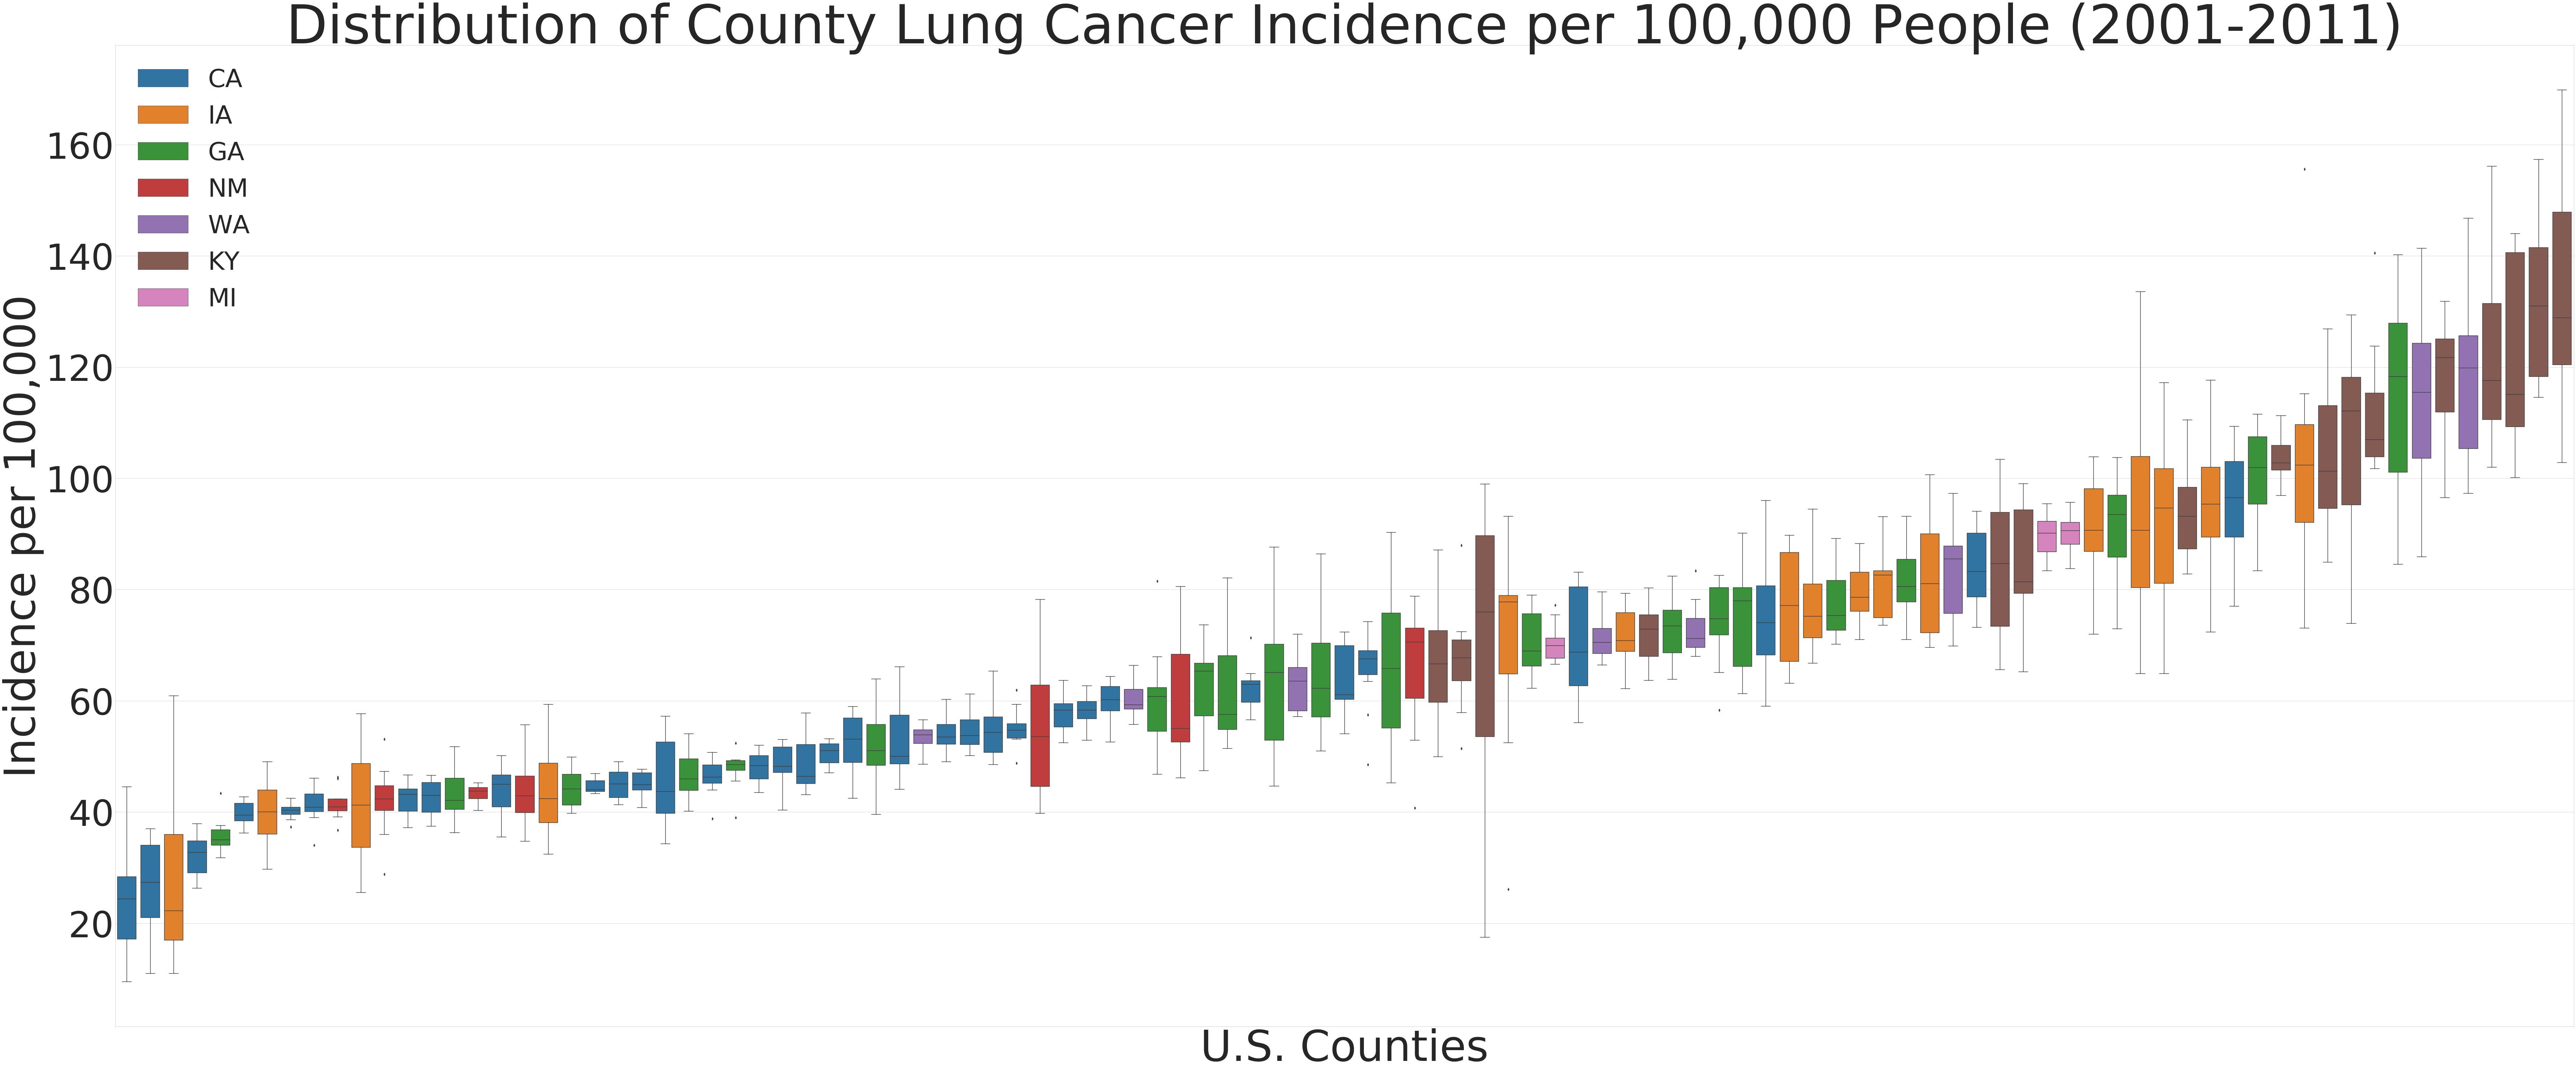

In [20]:
fig = plt.subplots(figsize=(100,40))
ax = sns.boxplot(x='State_and_county', y='cancer_incidence_x', hue='State',data=df_lung, dodge=False)

ax.set_xlabel('U.S. Counties', fontsize=120)
ax.set_ylabel('Incidence per 100,000', fontsize=120)

ax.tick_params(labelsize=100)
plt.xticks([], [])
plt.legend(loc='upper left', fontsize=70)
plt.tight_layout()
plt.title('Distribution of County Lung Cancer Incidence per 100,000 People (2001-2011)', fontsize=150)

Text(0.5,1,'Distribution of Mean County-Wide Lung Cancer Incidence per 100,000 People (2001-2011) Grouped by State')

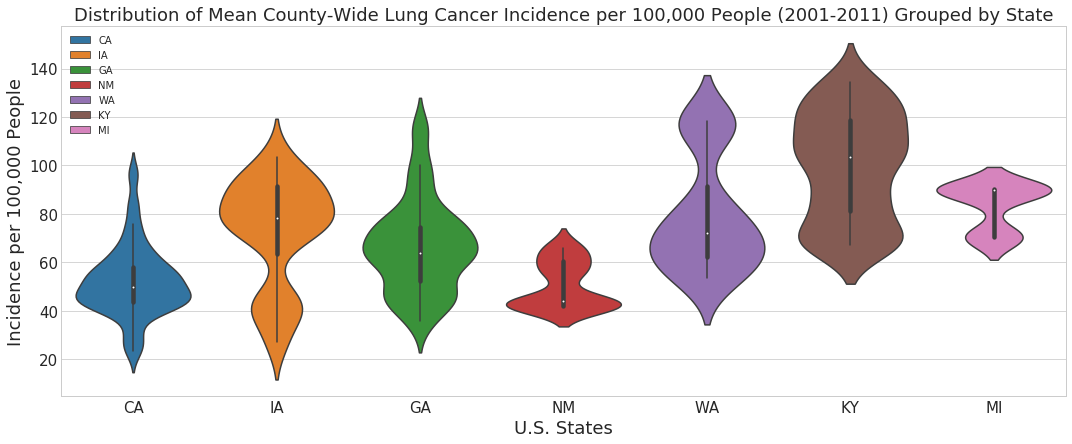

In [21]:
fig = plt.subplots(figsize=(15,6))
ax = sns.violinplot(x='State', y='cancer_incidence_y', hue='State', dodge=False, data=df_lung)

ax.set_xlabel('U.S. States', fontsize=18)
ax.set_ylabel('Incidence per 100,000 People', fontsize=18)
ax.tick_params(labelsize=15)
ax.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.title('Distribution of Mean County-Wide Lung Cancer Incidence per 100,000 People (2001-2011) Grouped by State', fontsize=18)

In [22]:
print ('Michigan counties: '+str(df_lung[df_lung['State']=='MI']['State_and_county'].count()//11))
print ('California counties: '+str(df_lung[df_lung['State']=='CA']['State_and_county'].count()//11))
print ('Kentucky counties: '+str(df_lung[df_lung['State']=='KY']['State_and_county'].count()//11))
print ('Georgia counties: '+str(df_lung[df_lung['State']=='GA']['State_and_county'].count()//11))
print ('New Mexico counties: '+str(df_lung[df_lung['State']=='NM']['State_and_county'].count()//11))
print ('Iowa counties: '+str(df_lung[df_lung['State']=='IA']['State_and_county'].count()//11))
print ('Washington counties: '+str(df_lung[df_lung['State']=='WA']['State_and_county'].count()//11))

Michigan counties: 3
California counties: 34
Kentucky counties: 16
Georgia counties: 21
New Mexico counties: 7
Iowa counties: 16
Washington counties: 8


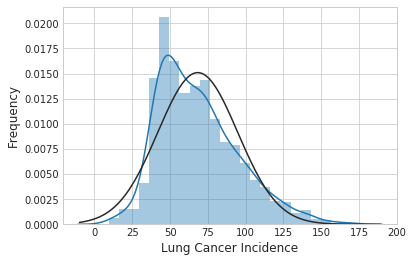

In [23]:
ax = sns.distplot(df_lung['cancer_incidence_x'], fit=norm)
ax.set_xlabel('Lung Cancer Incidence', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.tick_params(labelsize=10)

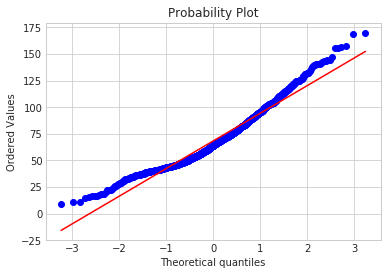

In [24]:
res = probplot(df_lung['cancer_incidence_x'], plot=plt)

Text(0.5,0,'Mean Radon Levels (pCi/L)')

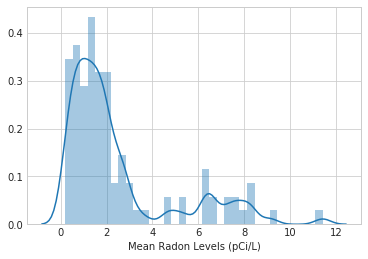

In [26]:
sns.distplot(df_lung.radon_mean)
plt.xlabel('Mean Radon Levels (pCi/L)', fontsize=10)

In [27]:
df_lung['log_radon'] = np.log(df_lung['radon_mean'])

Text(0.5,0,'Mean Log Radon Levels (pCi/L)')

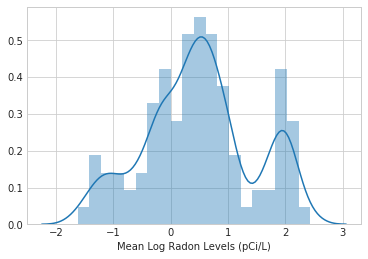

In [29]:
sns.distplot(df_lung['log_radon'])
plt.xlabel('Mean Log Radon Levels (pCi/L)', fontsize=10)

/home/davidhenslovitz/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/davidhenslovitz/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/davidhenslovitz/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

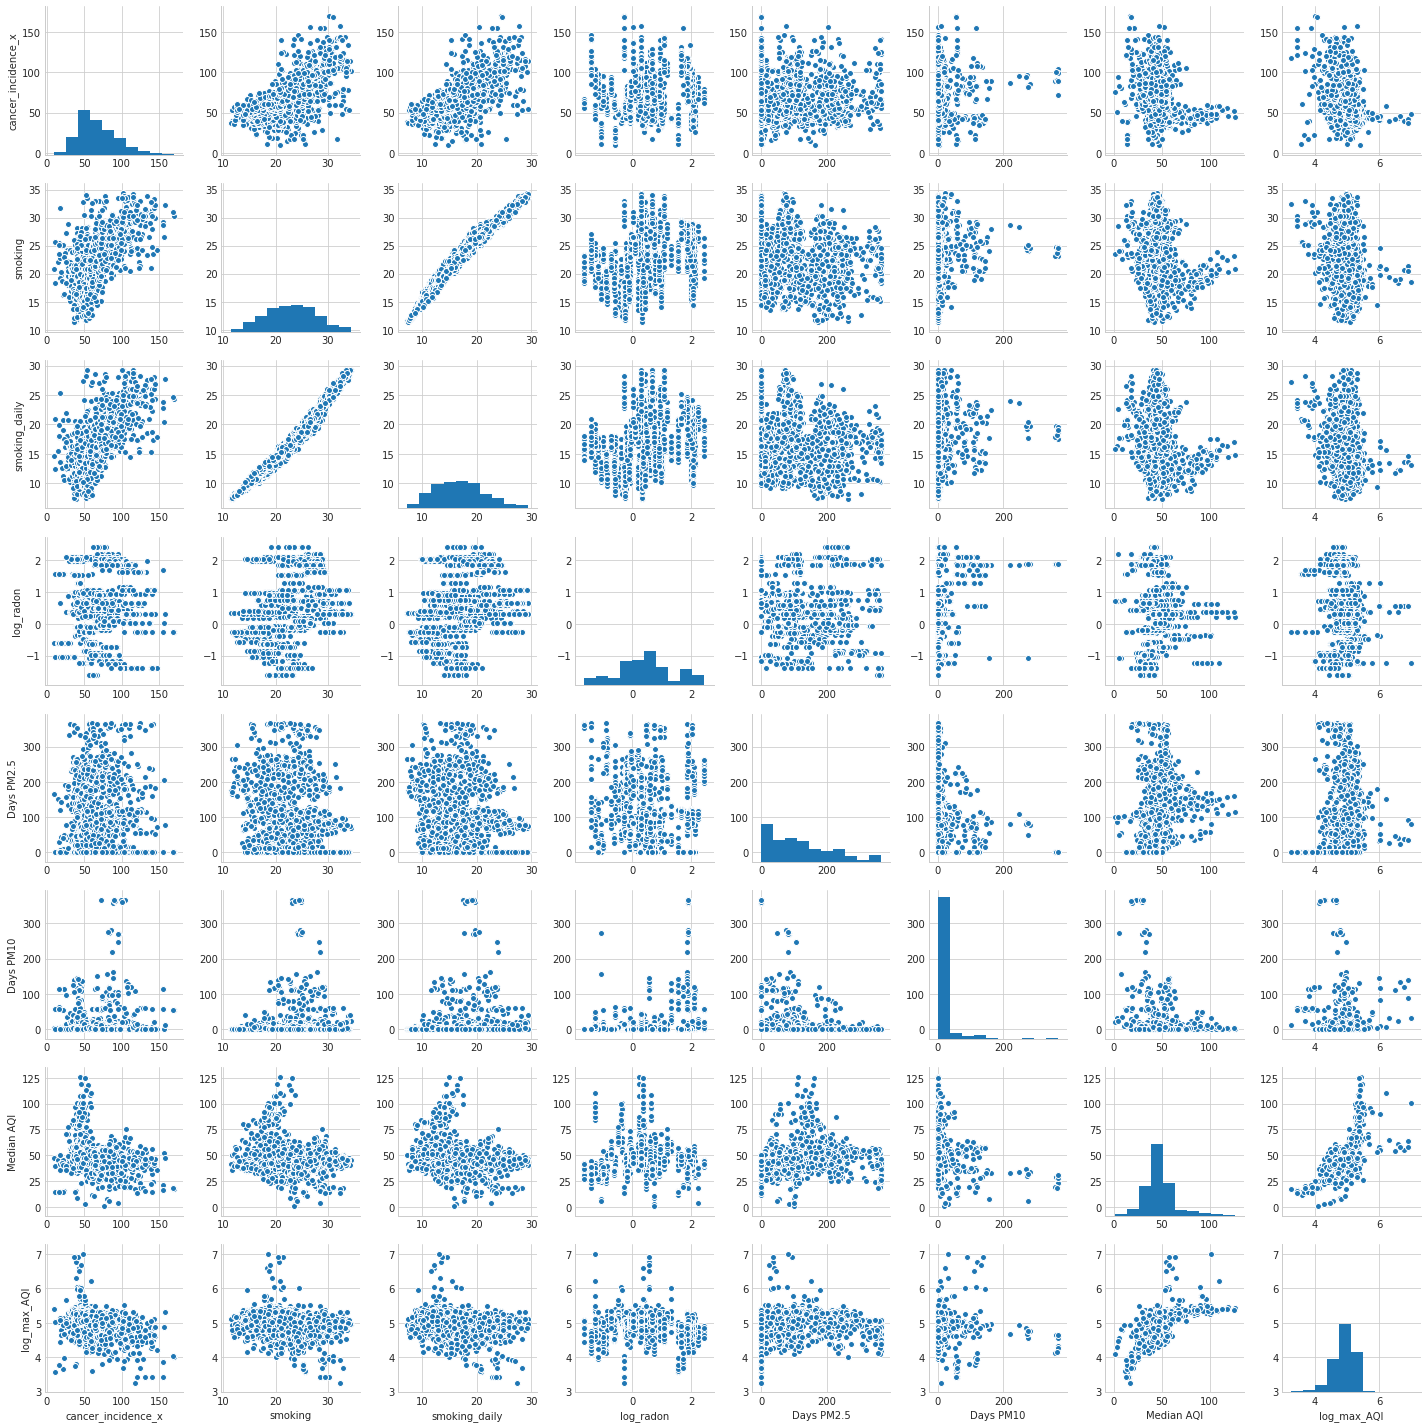

In [30]:
df_lung['log_radon'] = np.log(df_lung['radon_mean'])
df_lung['log_ozone'] = np.log(df_lung['ozone'])
df_lung['log_ozone'][np.isneginf(df_lung['log_ozone'])] = 0

df_lung['log_max_AQI'] = np.log(df_lung['Max AQI'])
df_lung['log_max_AQI'][np.isneginf(df_lung['log_max_AQI'])] = 0
df_lung['log_pm25'] = np.log(df_lung['Days PM2.5'])
df_lung['log_pm25'][np.isneginf(df_lung['log_pm25'])] = 0

variables = df_lung[['cancer_incidence_x','smoking','smoking_daily', 'log_radon','Days PM2.5', 'Days PM10','Median AQI', 'log_max_AQI']]
sns.pairplot(variables)

In [31]:
X = df_lung[['cancer_incidence_x','smoking','smoking_daily', 'radon_mean','log_radon', 'Prob_low_radon', 'Prob_high_radon', 'Days PM2.5','log_pm25','pm25', 'pm25_perc','Days PM10', 'pm10_perc','Median AQI','Max AQI', 'log_max_AQI','ozone','log_ozone']]
y = X.pop('cancer_incidence_x')

In [32]:
radon_group = ['log_radon', 'radon_mean', 'Prob_low_radon', 'Prob_high_radon']
smoking_group = ['smoking', 'smoking_daily']
pm_25_group = ['Days PM2.5','log_pm25','pm25','pm25_perc']
pm_10_group = ['Days PM10', 'pm10_perc']
ozone_group = ['ozone', 'log_ozone']
aqi_group = ['Median AQI', 'Max AQI','log_max_AQI']
tri_group = ['ON-SITE_RELEASE_TOTAL','log_releases']

In [33]:
bic_features = pd.DataFrame()
feature_list = []
bic_list = []
for s in smoking_group:
    for a in aqi_group:
        for r in radon_group:
            for t in tri_group:
                for p in pm_25_group:
                    for n in pm_10_group:
                        for o in ozone_group:
                            X_new = X[[s,a,r,p]]

                            model_bic = LassoLarsIC(criterion='bic')
                            t1 = time.time()
                            model_bic.fit(X_new, y)
                            t_bic = time.time() - t1
                            alpha_bic_ = model_bic.alpha_
                            feature_list.append([s, a,r,p])
                            bic_list.append(model_bic.criterion_.min())

In [34]:
bic_features['features'] = feature_list
bic_features['BIC'] = bic_list
bic_features.sort_values(by='BIC', ascending=True)

,features,BIC
384,"[smoking_daily, Median AQI, log_radon, Days PM...",565.572602
385,"[smoking_daily, Median AQI, log_radon, Days PM...",565.572602
386,"[smoking_daily, Median AQI, log_radon, Days PM...",565.572602
387,"[smoking_daily, Median AQI, log_radon, Days PM...",565.572602
403,"[smoking_daily, Median AQI, log_radon, Days PM...",565.572602
402,"[smoking_daily, Median AQI, log_radon, Days PM...",565.572602
401,"[smoking_daily, Median AQI, log_radon, Days PM...",565.572602
400,"[smoking_daily, Median AQI, log_radon, Days PM...",565.572602
412,"[smoking_daily, Median AQI, log_radon, pm25_perc]",565.615838
415,"[smoking_daily, Median AQI, log_radon, pm25_perc]",565.615838


In [35]:
bic_features.sort_values(by='BIC', ascending=True).iloc[0][0]

['smoking_daily', 'Median AQI', 'log_radon', 'Days PM2.5']

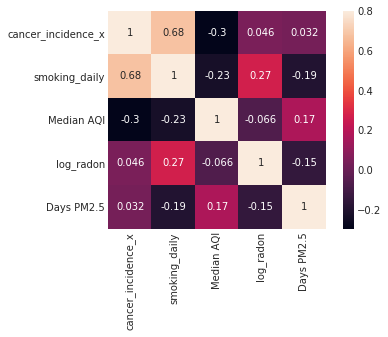

In [36]:
corrmat = df_lung[['cancer_incidence_x',
 'smoking_daily',
 'Median AQI',                 
 'log_radon',
 'Days PM2.5']].corr()
sns.heatmap(corrmat, annot=True, vmax=.8, square=True)

In [37]:
df_lung.year.value_counts()

2011    105
2010    105
2009    105
2008    105
2007    105
2006    105
2005    105
2004    105
2003    105
2002    105
2001    105
Name: year, dtype: int64

In [38]:
df = df_lung[['State_and_county','year','cancer_incidence_x','smoking','smoking_daily','pm25','ozone', 'radon_mean','Prob_low_radon','Prob_high_radon','Days PM2.5','Median AQI','Max AQI']]
df.index = df['State_and_county']
df = df[df.index.value_counts()>10]

df['State'] = df['State_and_county'].str[-2:]

scaler = preprocessing.StandardScaler()
y = df['cancer_incidence_x']
X = df[['smoking_daily', 'Days PM2.5','Median AQI', 'radon_mean']]
X = scaler.fit_transform(X)
df.head()

/home/davidhenslovitz/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,State_and_county,year,cancer_incidence_x,smoking,smoking_daily,pm25,ozone,radon_mean,Prob_low_radon,Prob_high_radon,Days PM2.5,Median AQI,Max AQI,State
State_and_county,,,,,,,,,,,,,,
"Colusa County, CA","Colusa County, CA",2008,9.463424,20.9,14.7,11.858425,1.0,0.55,0.025538,0.974462,165.0,47.0,220.0,CA
"Colusa County, CA","Colusa County, CA",2006,14.360938,22.1,15.5,10.160168,1.0,0.55,0.025538,0.974462,150.0,45.0,154.0,CA
"Colusa County, CA","Colusa County, CA",2001,26.285354,24.2,18.0,10.387352,12.0,0.55,0.025538,0.974462,39.0,42.0,156.0,CA
"Colusa County, CA","Colusa County, CA",2002,15.599002,25.4,17.8,11.927744,4.0,0.55,0.025538,0.974462,29.0,41.0,152.0,CA
"Colusa County, CA","Colusa County, CA",2003,30.662306,24.3,17.2,10.772772,0.0,0.55,0.025538,0.974462,45.0,38.0,101.0,CA


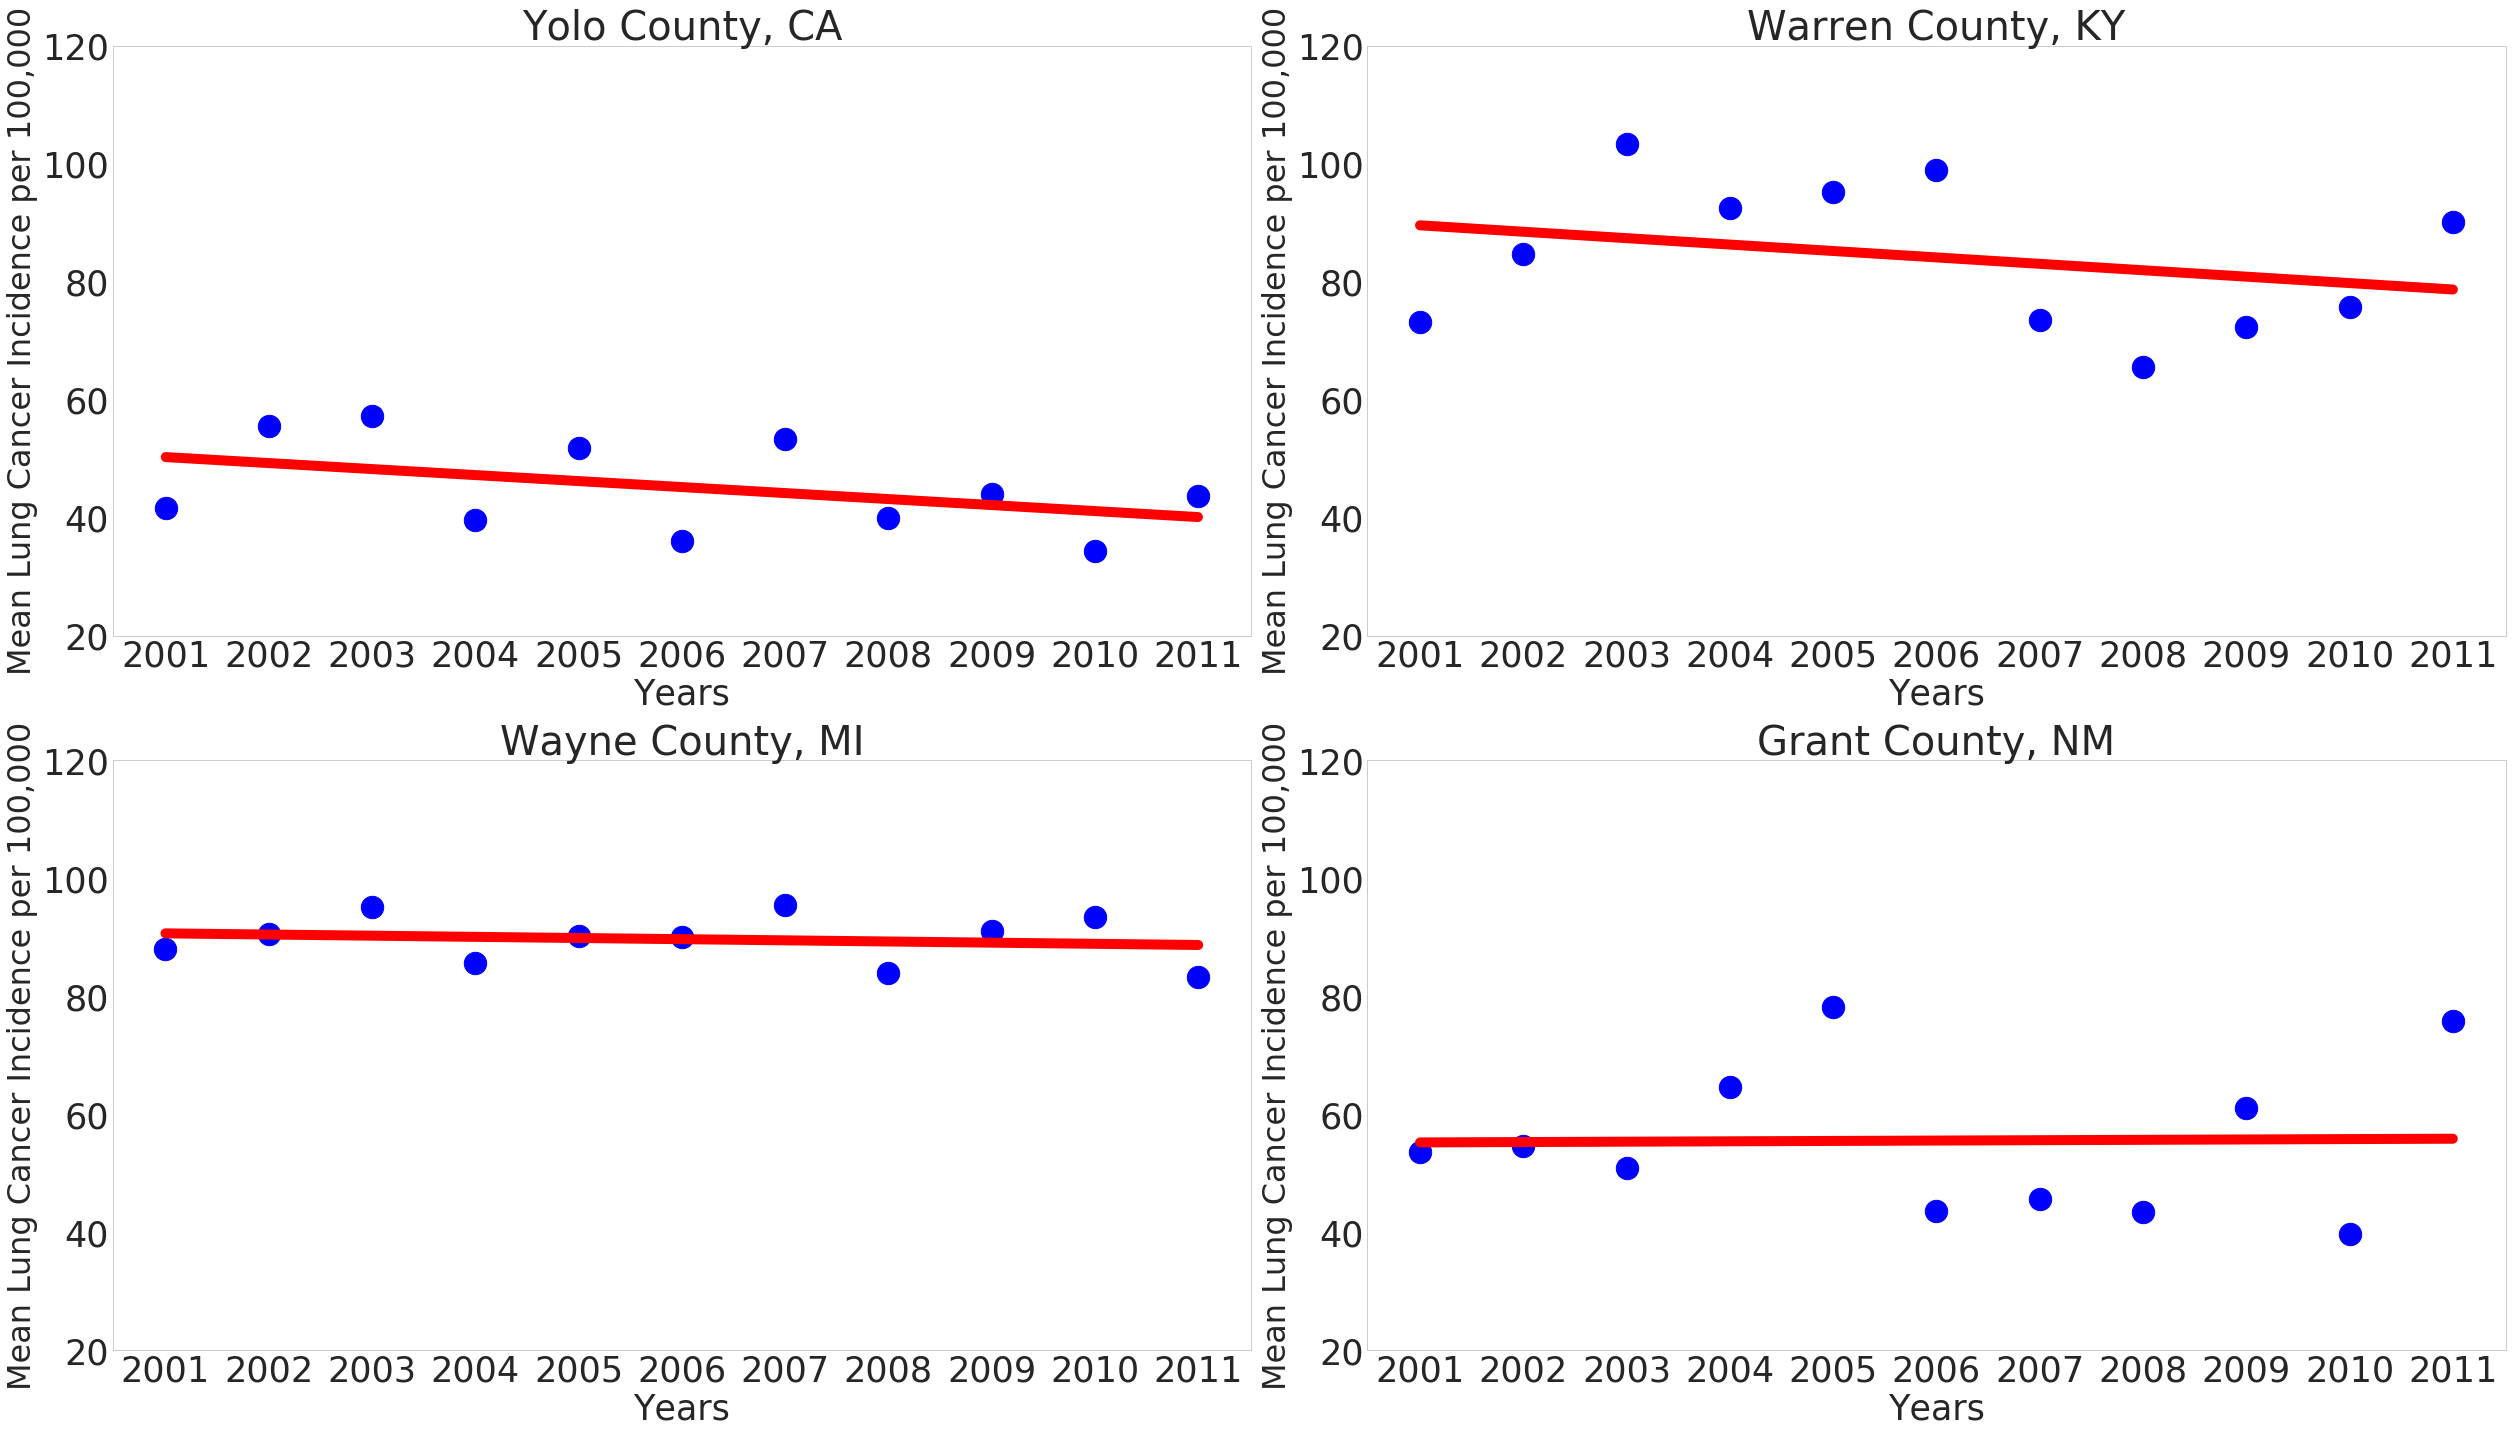

In [39]:
four_counties = ['Yolo County, CA','Warren County, KY', 'Wayne County, MI', 'Grant County, NM']

fig, ax = plt.subplots(2,2,figsize=(35,20))
counter = 1
for c in four_counties:

    plt.subplot(2,2,counter)
    plt.grid(False)
    plt.scatter([str(i) for i in range(2001,2012)],df.loc[c].cancer_incidence_x.values, color='blue', s=500)
    X = np.array([int(i) for i in range(2001,2012)])
    Y = np.array(df.loc[c].cancer_incidence_x.values)
    fit = np.polyfit(X, Y, deg=1)
    plt.plot(X, fit[0] * X + fit[1], color='red', lw=10)
    
    plt.xlabel('Years', fontsize=35)
    plt.ylabel('Mean Lung Cancer Incidence per 100,000', fontsize=32)
    plt.title(c, fontsize=40)
    plt.tick_params(labelsize=35)
    plt.ylim([20,120])
    counter += 1
    plt.tight_layout()